In [ ]:
! pip install --upgrade category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/feature_set_combined.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Patient,lesion_area,lesion_aspect_ratio,irregularityIndex,lesion_mean,lesion_std,target_variable
0,M_1,0.360184,0.485944,1.090614,0.290971,0.148869,1
1,M_2,0.365356,0.963351,1.142170,0.298261,0.183889,1
2,M_3,0.071426,0.870968,1.089891,0.338956,0.140398,1
3,M_4,0.072891,0.705882,1.090672,0.378555,0.158894,1
4,M_5,0.067657,0.787234,1.093063,0.363167,0.154853,1


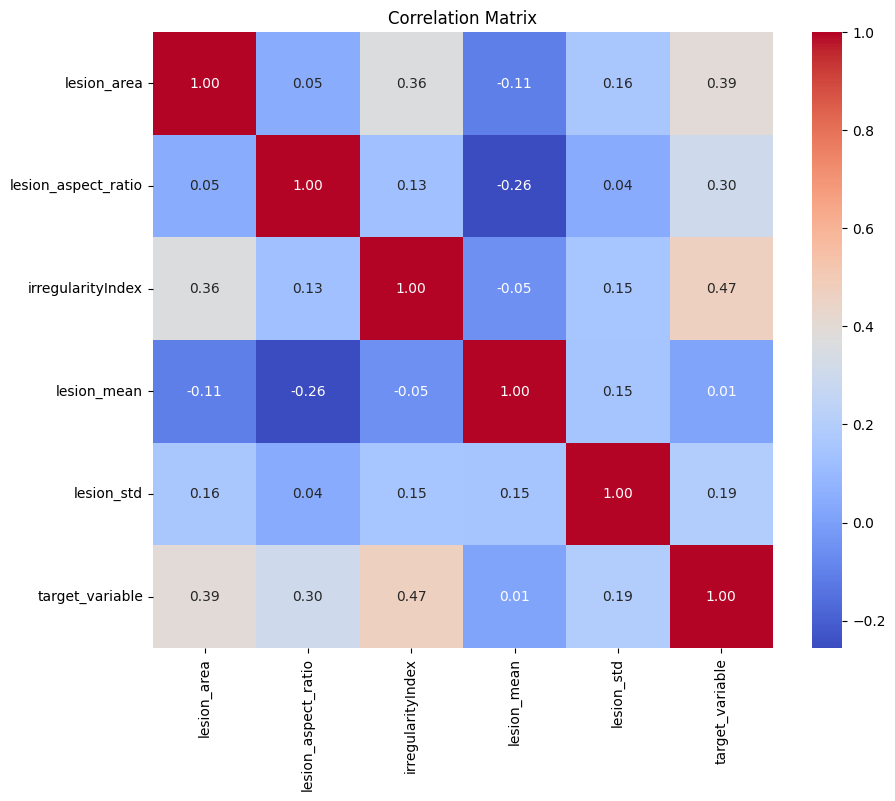

In [ ]:
# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
y = df['target_variable']

In [ ]:
X = df.drop(['Patient', 'target_variable'], axis=1)

In [ ]:
X.head()

,lesion_area,lesion_aspect_ratio,irregularityIndex,lesion_mean,lesion_std
0,0.360184,0.485944,1.090614,0.290971,0.148869
1,0.365356,0.963351,1.142170,0.298261,0.183889
2,0.071426,0.870968,1.089891,0.338956,0.140398
3,0.072891,0.705882,1.090672,0.378555,0.158894
4,0.067657,0.787234,1.093063,0.363167,0.154853


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [ ]:
input_shape = [X_train.shape[1]]

In [ ]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(256, activation= 'relu',),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(256, activation= 'relu',),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model using binary cross-entropy loss (for binary classification)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')  # Adding ROC-AUC as a metric
    ]
)

In [ ]:
# Defining a simple learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    decay = 0.96  # Learning rate decay factor
    lr = initial_lr * decay**epoch
    return lr

# Creating a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.0001,
    restore_best_weights=True,
)

In [ ]:
# Define the number of folds
k = 10

# Initialize KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define lists to store performance metrics
fold_accuracies = []
fold_roc_aucs = []

# Loop over each fold
for train_index, val_index in kf.split(X):
    # Use .iloc for pandas DataFrame to access rows based on indices
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [ ]:
# Model training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=200,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9052 - auc: 0.9612 - loss: 0.2261 - val_accuracy: 0.9531 - val_auc: 0.9864 - val_loss: 0.1460
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8879 - auc: 0.9457 - loss: 0.2703 - val_accuracy: 0.9688 - val_auc: 0.9801 - val_loss: 0.1439
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8573 - auc: 0.9241 - loss: 0.3182 - val_accuracy: 0.9688 - val_auc: 0.9795 - val_loss: 0.1456
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8857 - auc: 0.9474 - loss: 0.2775 - val_accuracy: 0.9688 - val_auc: 0.9812 - val_loss: 0.1461
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8772 - auc: 0.9288 - loss: 0.3128 - val_accuracy: 0.9688 - val_auc: 0.9812 - val_loss: 0.1435
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8837 - auc: 0.9444 - loss: 0.2848 - val_accuracy: 0.9688 - val_auc: 0.9818 - val_loss: 0.1452
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_auc = model.evaluate(X_val, y_val)

# Save accuracy and ROC AUC for this fold
fold_accuracies.append(val_accuracy)
fold_roc_aucs.append(val_auc)

# Compute the average accuracy and AUC across all folds
mean_accuracy = np.mean(fold_accuracies)
mean_roc_auc = np.mean(fold_roc_aucs)

print(f"Average Accuracy over {k} folds: {mean_accuracy}")
print(f"Average ROC-AUC over {k} folds: {mean_roc_auc}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9583 - auc: 0.9840 - loss: 0.1605
Average Accuracy over 10 folds: 0.96875
Average ROC-AUC over 10 folds: 0.981249988079071


<Axes: title={'center': 'ROC-AUC'}>

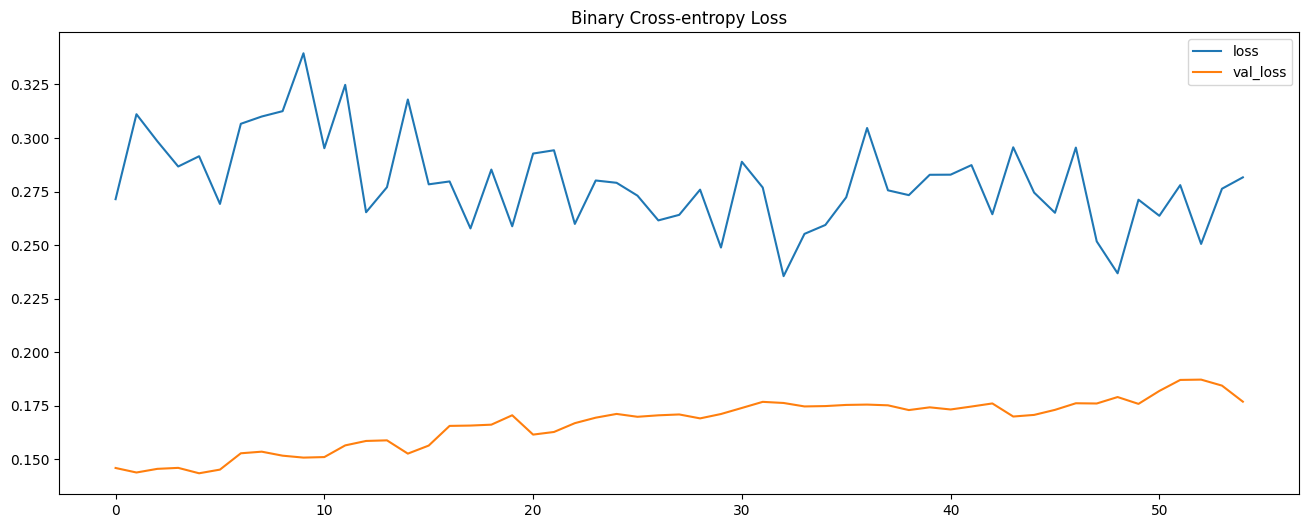

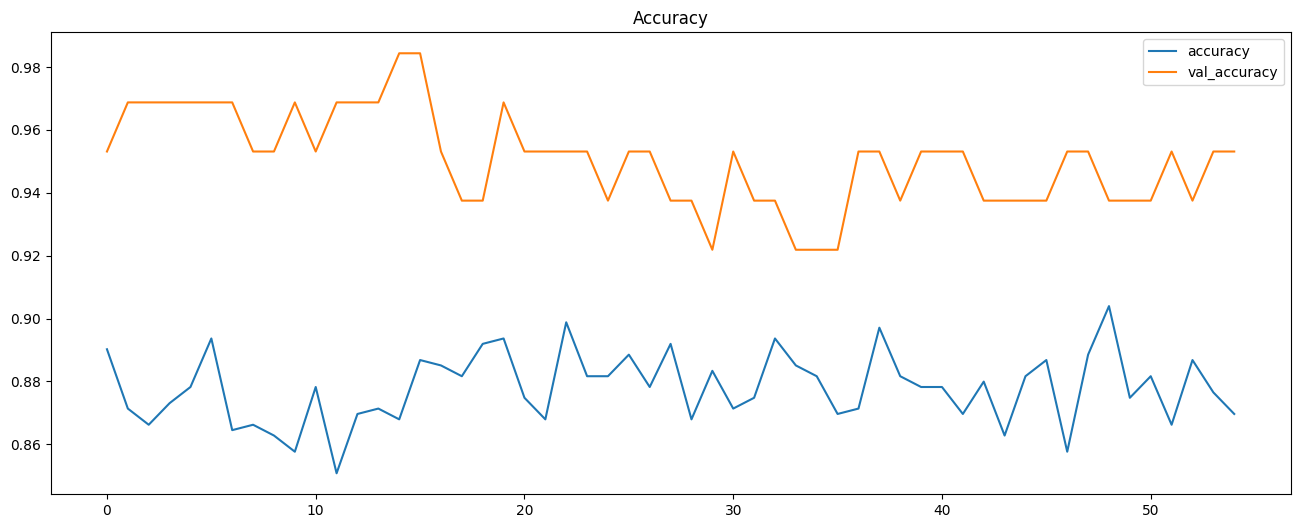

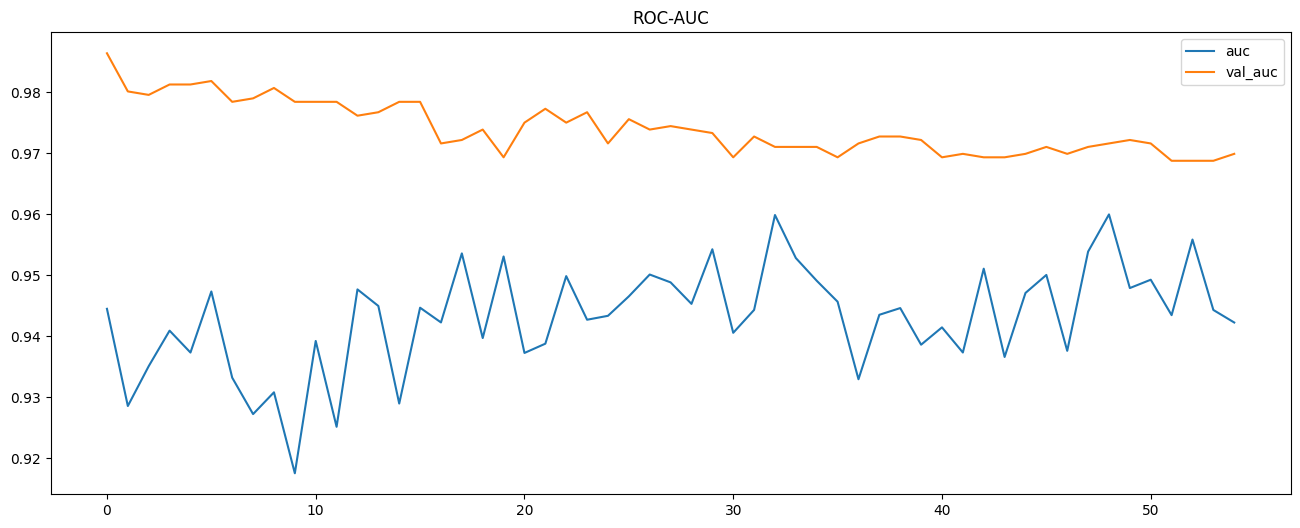

In [ ]:
# Model evaluation
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Binary Cross-entropy Loss", figsize=(16, 6))
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy", figsize=(16, 6))
history_df.loc[:, ['auc', 'val_auc']].plot(title="ROC-AUC", figsize=(16, 6))

In [ ]:
# Generate predictions (probabilities) on the validation set
y_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions (threshold 0.5 for binary classification)
y_pred = (y_pred_prob > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


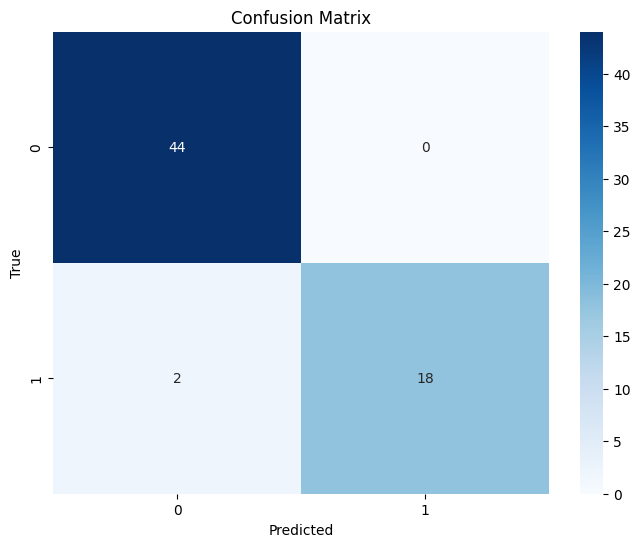

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print classification report
report = classification_report(y_val, y_pred, target_names=['0', '1'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.90      0.95        20

    accuracy                           0.97        64
   macro avg       0.98      0.95      0.96        64
weighted avg       0.97      0.97      0.97        64



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


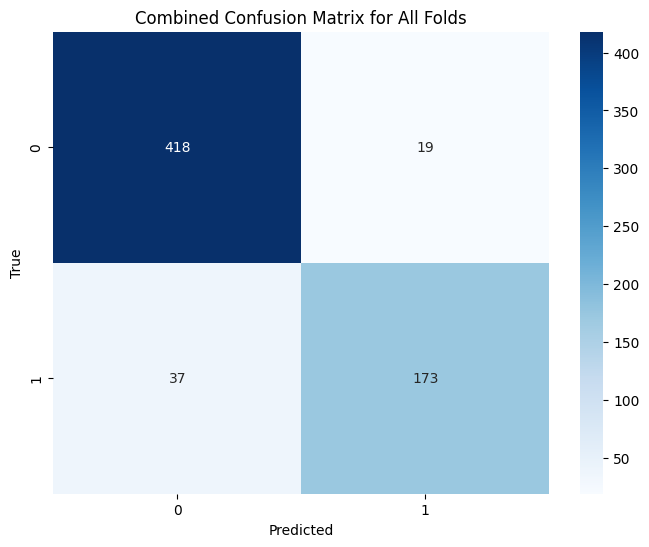

Combined Classification Report for All Folds:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       437
           1       0.90      0.82      0.86       210

    accuracy                           0.91       647
   macro avg       0.91      0.89      0.90       647
weighted avg       0.91      0.91      0.91       647



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize lists to collect the true labels and predictions for all folds
all_y_true = []
all_y_pred = []

# Loop over each fold (this part assumes you already have the code for k-fold split and model training)
for train_index, val_index in kf.split(X):
    # Split data into training and validation sets for this fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train your model here (assuming it's already defined and compiled)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)  # Example, use your training loop

    # Generate predictions for the validation set
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Collect true labels and predictions from this fold
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

# After looping through all folds, convert the collected lists to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Generate combined confusion matrix for all folds
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot combined confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix for All Folds')
plt.show()

# Generate combined classification report for all folds
report = classification_report(all_y_true, all_y_pred, target_names=['0', '1'])
print("Combined Classification Report for All Folds:\n", report)
